In [1]:
%load_ext autoreload
%autoreload 2

# ignore warnings for readability
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
import torch.nn as nn

import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior
from ili.embedding import FCN


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cuda


In [2]:
# create synthetic catalog
def simulator(params):
    # create toy simulations
    x = np.arange(10)
    y = 3 * params[0] * np.sin(x) + params[1] * x ** 2 - 2 * params[2] * x
    y += np.random.randn(len(x))
    return y

seed_sim = 12345
np.random.seed(seed_sim)
theta = np.random.rand(200, 3)  # 200 simulations, 3 parameters
x = np.array([simulator(t) for t in theta])

# make a dataloader
loader = NumpyLoader(x=x, theta=theta)

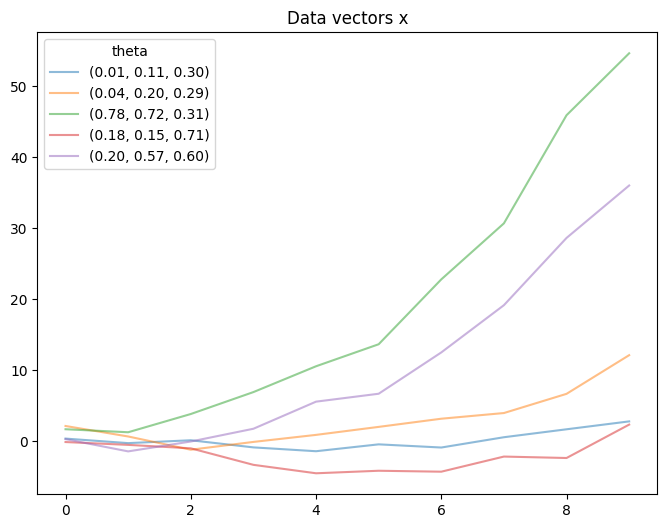

In [3]:
# plot some examples of the data
fig, ax = plt.subplots(figsize=(8, 6))
for i in range(5):
    ind = np.random.randint(len(theta))
    ax.plot(x[ind], alpha=0.5, label=f'(%.2f, %.2f, %.2f)' % tuple(theta[ind]))
ax.legend(title='theta')
ax.set_title('Data vectors x')
plt.show()

In [4]:
# define a prior
prior = ili.utils.Uniform(low=[0, 0, 0], high=[1, 1, 1], device=device)

# instantiate your neural networks to be used as an ensemble
nets = [
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=50, num_transforms=5),
    ili.utils.load_nde_sbi(engine='NPE', model='mdn', hidden_features=50, num_components=6)
]

# define training arguments
train_args = {
    'training_batch_size': 32,
    'learning_rate': 1e-4
}

embedding_net = FCN(n_hidden=[256, 256, 256, 256], act_fn="SiLU")

# initialize the trainer
runner = InferenceRunner.load(
    backend='sbi',
    engine='NPE',
    prior=prior,
    nets=nets,
    device=device,
    embedding_net=embedding_net,
    train_args=train_args,
    proposal=None,
    out_dir=None
)

In [5]:
# train the model
posterior_ensemble, summaries = runner(loader=loader)

INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 2.


 Neural network successfully converged after 520 epochs.

INFO:root:Training model 2 / 2.


 Neural network successfully converged after 448 epochs.

INFO:root:It took 61.31103253364563 seconds to train models.


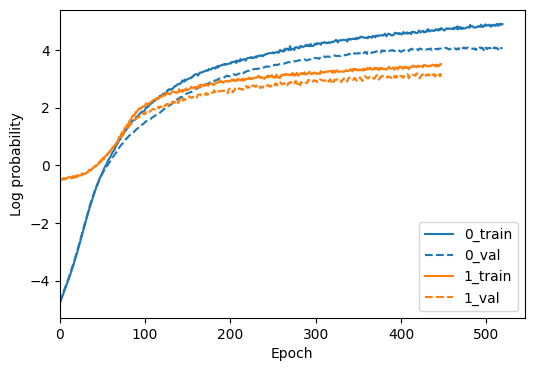

In [6]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

In [7]:
# Now, SBIRunner returns a custom class instance to be able to pass signature strings
# This class has simply for attributes a NeuralPosteriorEstimate and a string list 
print(posterior_ensemble.signatures)

# choose a random input
seed_in = 49
np.random.seed(seed_in)
ind = np.random.randint(len(theta))

# generate samples from the posterior using accept/reject sampling
seed_samp = 32
torch.manual_seed(seed_samp)
samples = posterior_ensemble.sample((1000,), torch.Tensor(x[ind]).to(device))

# calculate the log_prob for each sample
log_prob = posterior_ensemble.log_prob(samples, torch.Tensor(x[ind]).to(device))

samples = samples.cpu().numpy()
log_prob = log_prob.cpu().numpy()

['', '']


Drawing 718 posterior samples:   0%|          | 0/718 [00:00<?, ?it/s]

Drawing 282 posterior samples:   0%|          | 0/282 [00:00<?, ?it/s]

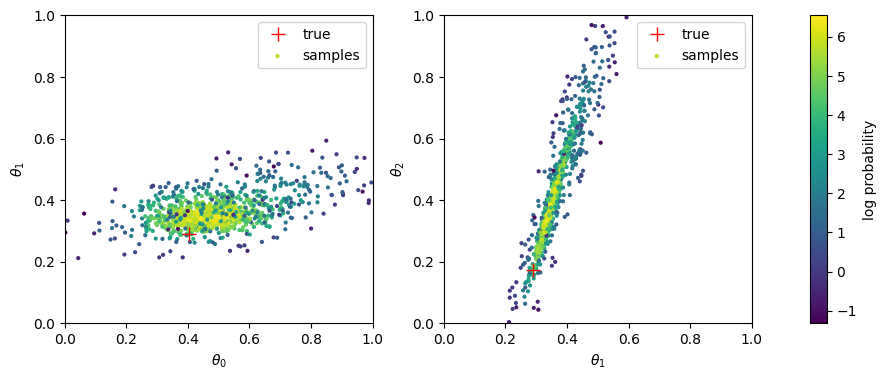

In [8]:
# plot the posterior samples and the true value
fig, axs = plt.subplots(1, 3, figsize=(10,4), gridspec_kw={'width_ratios': [1,1,0.05]})
for i in range(2):
    axs[i].plot(theta[ind,i], theta[ind,i+1], 'r+', markersize=10, label='true')
    im = axs[i].scatter(samples[:,i], samples[:,i+1], c=log_prob, s=4, label='samples')
    axs[i].set_aspect('equal')
    axs[i].set_xlim(0,1)
    axs[i].set_ylim(0,1)
    axs[i].set_xlabel(f'$\\theta_{i}$')
    axs[i].set_ylabel(f'$\\theta_{i+1}$')
    axs[i].legend()
plt.colorbar(im, label='log probability', use_gridspec=True, cax=axs[2])

Drawing 734 posterior samples:   0%|          | 0/734 [00:00<?, ?it/s]

Drawing 266 posterior samples:   0%|          | 0/266 [00:00<?, ?it/s]

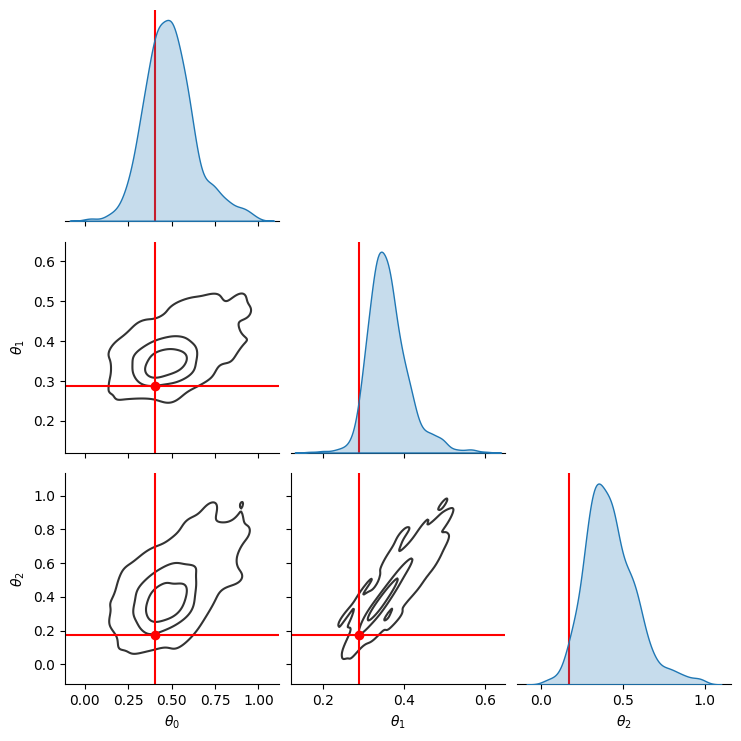

In [9]:
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct', 
    labels=[f'$\\theta_{i}$' for i in range(3)]
)
fig = metric(
    posterior=posterior_ensemble,
    x_obs = x[ind], theta_fid=theta[ind]
)

100%|██████████| 100/100 [00:00<00:00, 101.78it/s]


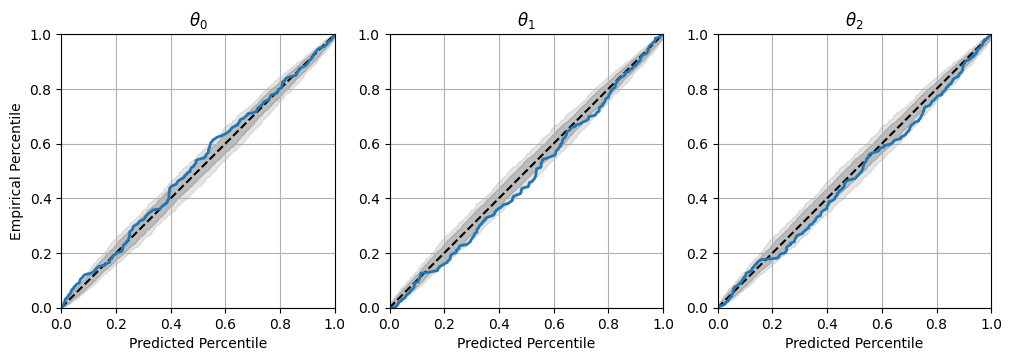

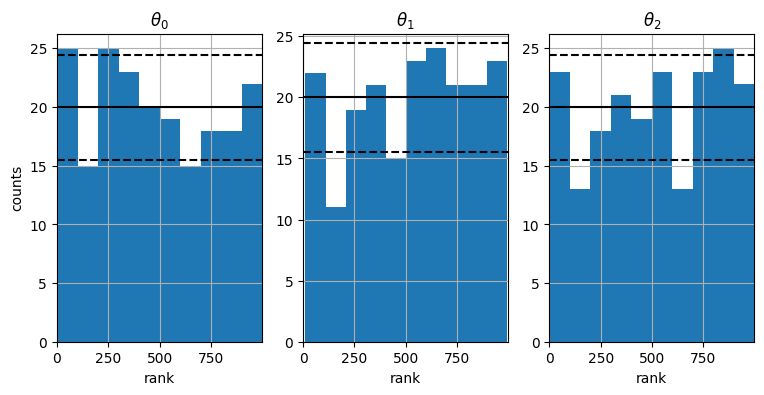

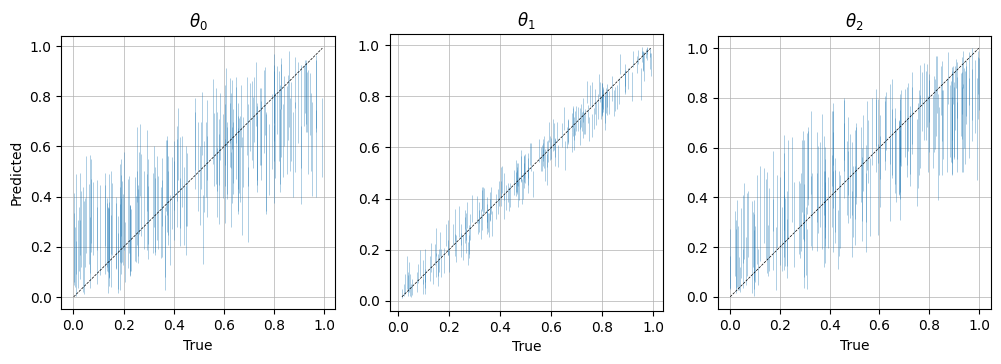

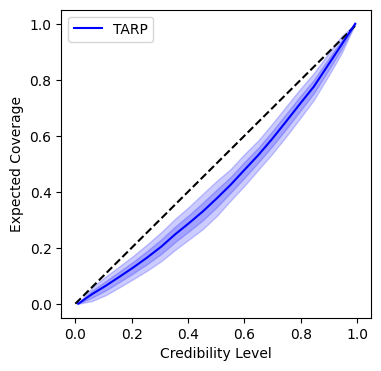

In [10]:
# Drawing samples from the ensemble posterior

metric = PosteriorCoverage(
    num_samples=1000, sample_method='direct', 
    labels=[f'$\\theta_{i}$' for i in range(3)],
    plot_list = ["coverage", "histogram", "predictions", "tarp"],
    out_dir=None
)

fig = metric(
    posterior=posterior_ensemble, # NeuralPosteriorEnsemble instance from sbi package
    x=x, theta=theta
)

# CNN

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import sbi
from scipy.stats import gaussian_kde
import torch
import yaml

from CASBI.generator.fff.fff_model import FreeFormFlow

test_number = '28'
with open(f'../../data/tuning/test_{test_number}/hyperparameters.yaml', 'r') as file:
    # Load the contents of the file
    hyperparameters = yaml.safe_load(file)

Flow = FreeFormFlow(dim = 2, 
                    cond_dim = hyperparameters['cond_dim'],
                    hidden_dim = hyperparameters['hidden_dim'],
                    latent_dim = 2,
                    n_SC_layer = hyperparameters['n_SC_layer'],
                    beta = hyperparameters['beta'],
                    device = 'cuda:0'
                    )
Flow.load_state_dict(torch.load(f'../../data/tuning/test_{test_number}/snapshot.pth'))


data = pd.read_parquet('../../data/dataframe/dataframe.parquet')
min_feh, max_feh = min(data['feh']), max(data['feh'])
min_ofe, max_ofe = min(data['ofe']), max(data['ofe'])
data =  data.drop(['a','redshift', 'mean_FeMassFrac', 'std_FeMassFrac', 'mean_OMassFrac', 'std_OMassFrac'], axis=1)
conditions = data[data.columns.difference(['feh', 'ofe', 'Galaxy_name'], sort=False)].drop_duplicates()


def simulator(theta, model=Flow, n_halos=2, min_feh=min_feh, max_feh=max_feh, min_ofe=min_ofe, max_ofe=max_ofe):
    with torch.no_grad():
        model.eval()
        if len(theta.shape) == 1:
            for i in range(n_halos):
                if i==0:
                    cond = theta[i::n_halos].repeat(500, 1)
                    halo = model.sample(500, cond=cond)
                else:
                    cond = theta[i::n_halos].repeat(500, 1)
                    halo = torch.vstack((halo, model.sample(500, cond=cond))).to('cpu')
            batch_halos, _, _ = np.histogram2d(halo[:, 0], halo[:, 1], bins=64, range=[[min_feh, max_feh], [min_ofe, max_ofe]])
            batch_halos = np.expand_dims(batch_halos, axis=0)
            batch_halos = torch.log1p(torch.from_numpy(batch_halos+1e-6))
        
            
        else:
            batch_halos = torch.zeros(theta.shape[0], 1, 64 , 64)
            for n, batch in enumerate(theta):
                for i in range(n_halos):
                    if i==0:
                        cond = batch[i::n_halos].repeat(500, 1)
                        halo = model.sample(500, cond=cond)
                    else:
                        cond = batch[i::n_halos].repeat(500, 1)
                        halo = torch.vstack((halo, model.sample(500, cond=cond))).to('cpu')
                bh, _, _ = np.histogram2d(halo[:, 0], halo[:, 1], bins=64, range=[[min_feh, max_feh], [min_ofe, max_ofe]])
                bh = np.expand_dims(bh, axis=0)
                batch_halos[n] = torch.log1p(torch.from_numpy(bh + 1e-6))
        
        return batch_halos
    
minimum_theta = np.array(minimum_theta)
maximum_theta = np.array(maximum_theta)
def repeat_array(arr, repetitions):
    return np.repeat(arr, repetitions)
repeat_minimum_theta = repeat_array(minimum_theta, 2)
repeat_maximum_theta = repeat_array(maximum_theta, 2) 

prior = ili.utils.Uniform(low=repeat_minimum_theta, high=repeat_maximum_theta, device=device)
    


In [96]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(32 * 8 * 8, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        out = self.conv_layers(x)
        out = out.view(out.size(0), -1)
        out = self.fc_layers(out)
        return out

In [98]:
# instantiate a CNN embedding network
embedding_net = ConvNet()
# embdedding_net =  FCN(n_hidden=[256, 256, 256, 256], act_fn="SiLU")

# instantiate your neural networks to be used as an ensemble
nets = [
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=50, num_transforms=5,
                           embedding_net=embedding_net),
    ili.utils.load_nde_sbi(engine='NPE', model='mdn', hidden_features=50, num_components=6,
                           embedding_net=embedding_net)
]

# define training arguments
train_args = {
    'training_batch_size': 32,
    'learning_rate': 5e-5,
    'stop_after_epochs': 50
}

# initialize the trainer
runner = InferenceRunner.load(
    backend='sbi',
    engine='NPE',
    prior=prior,
    nets=nets,
    device=device,
    embedding_net=embedding_net,
    train_args=train_args,
    proposal=None,
    out_dir=None
)

In [87]:
theta = prior.sample((5000,))
theta.shape

x = simulator(theta)
x.shape

torch.Size([5000, 1, 64, 64])

In [99]:
loader = NumpyLoader(x=x, theta=theta)
# train the model. this outputs a posterior model and training logs
posterior_ensemble, summaries = runner(loader=loader)

INFO:root:MODEL INFERENCE CLASS: NPE


INFO:root:Training model 1 / 2.


 Training neural network. Epochs trained: 1Training neural network. Epochs trained: 2Training neural network. Epochs trained: 3Training neural network. Epochs trained: 4Training neural network. Epochs trained: 5Training neural network. Epochs trained: 6Training neural network. Epochs trained: 7Training neural network. Epochs trained: 8Training neural network. Epochs trained: 9Training neural network. Epochs trained: 10Training neural network. Epochs trained: 11Training neural network. Epochs trained: 12Training neural network. Epochs trained: 13Training neural network. Epochs trained: 14Training neural network. Epochs trained: 15Training neural network. Epochs trained: 16Training neural network. Epochs trained: 17Training neural network. Epochs trained: 18Training neural network. Epochs trained: 19Training neural network. Epochs trained: 20Training neural network. Epochs trained: 21Training neural network. Epochs trained: 22Training neural network. Epochs trained: 23Training neural net

INFO:root:Training model 2 / 2.


 Training neural network. Epochs trained: 1Training neural network. Epochs trained: 2Training neural network. Epochs trained: 3Training neural network. Epochs trained: 4Training neural network. Epochs trained: 5Training neural network. Epochs trained: 6Training neural network. Epochs trained: 7Training neural network. Epochs trained: 8Training neural network. Epochs trained: 9Training neural network. Epochs trained: 10Training neural network. Epochs trained: 11Training neural network. Epochs trained: 12Training neural network. Epochs trained: 13Training neural network. Epochs trained: 14Training neural network. Epochs trained: 15Training neural network. Epochs trained: 16Training neural network. Epochs trained: 17Training neural network. Epochs trained: 18Training neural network. Epochs trained: 19Training neural network. Epochs trained: 20Training neural network. Epochs trained: 21Training neural network. Epochs trained: 22Training neural network. Epochs trained: 23Training neural net

INFO:root:It took 499.77758383750916 seconds to train models.


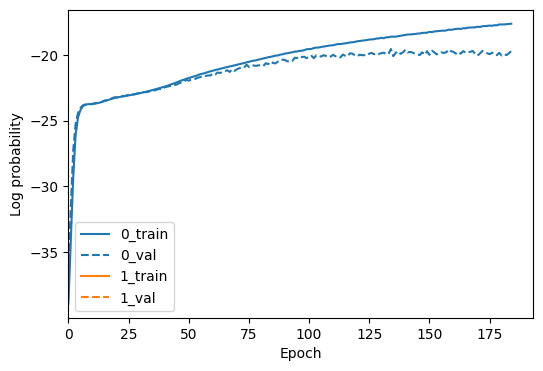

In [100]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

In [110]:
# choose a random input
ind = np.random.randint(len(theta))
x_test = torch.Tensor(x[ind]).to(device)

# generate samples from the posterior using accept/reject sampling
samples = posterior_ensemble.sample((5000,), x_test)
# calculate the log_prob for each sample
log_prob = posterior_ensemble.log_prob(samples, x_test)

samples = samples.cpu().numpy()
log_prob = log_prob.cpu().numpy()
theta = theta.cpu().numpy()

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

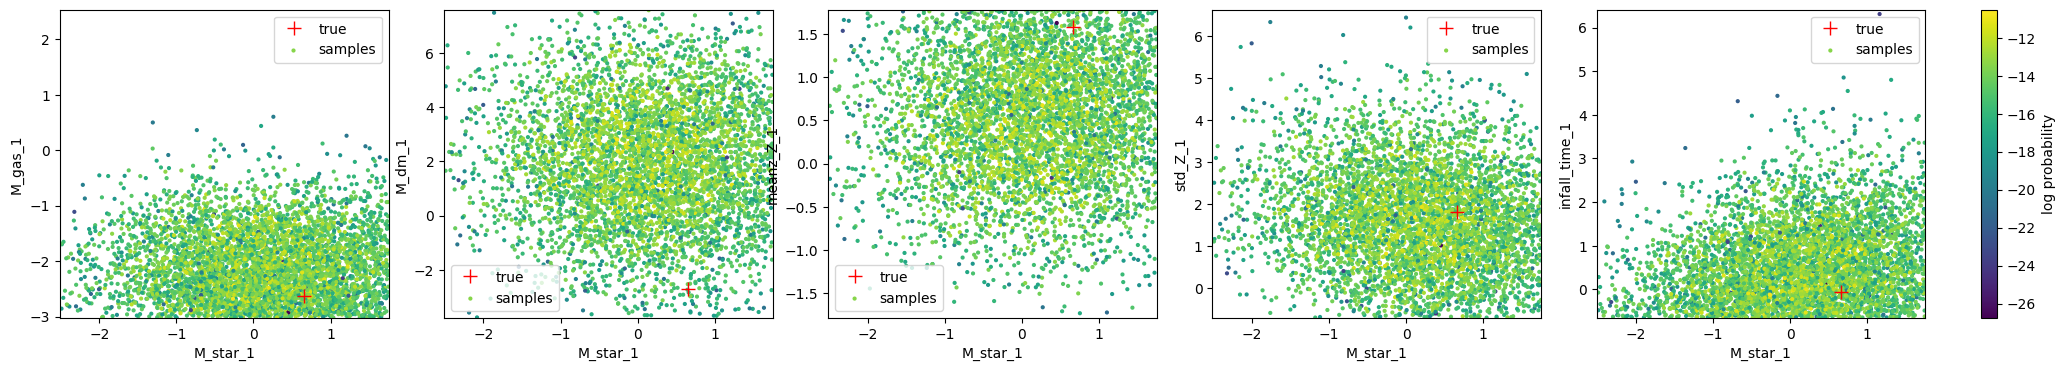

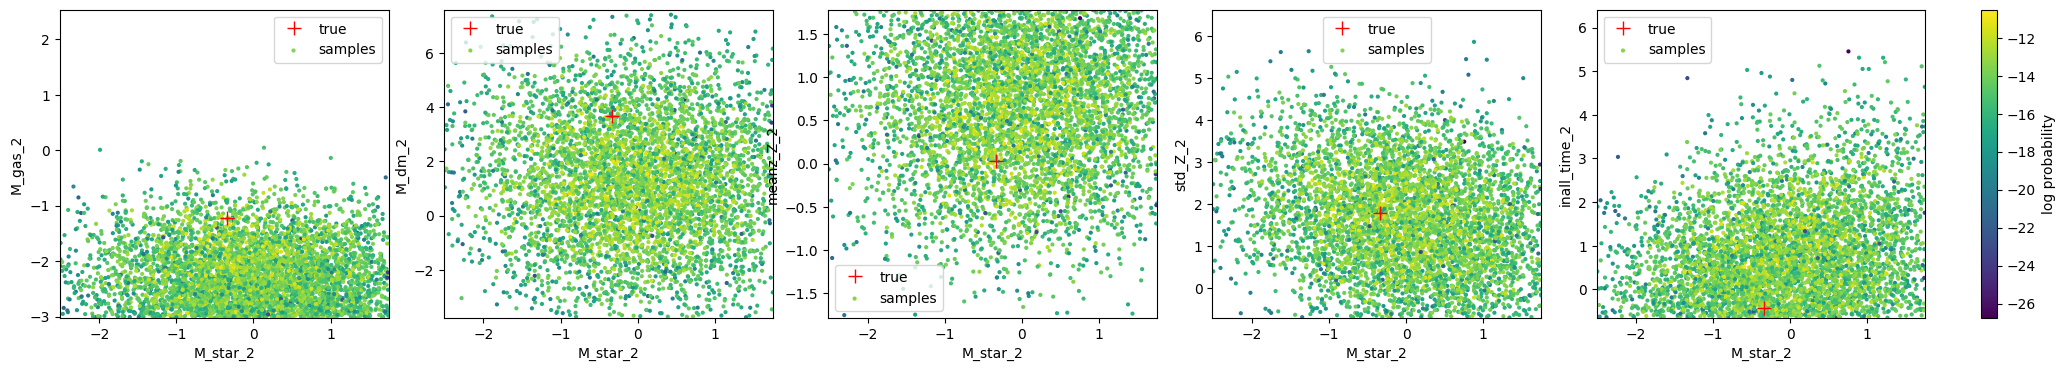

In [150]:
# plot the posterior samples and the true value
labels = ['M_star_1', 'M_star_2', 'M_gas_1', 'M_gas_2', 'M_dm_1', 'M_dm_2', 'meanz_Z_1', 'meanz_Z_2', 'std_Z_1', 'std_Z_2', 'infall_time_1', 'inall_time_2']
fig, axs = plt.subplots(1, 6, figsize=(25,4), gridspec_kw={'width_ratios': [1,1, 1, 1, 1, 0.05]})

for j, i in enumerate([2, 4, 6, 8, 10]):
    axs[j].plot(theta[ind,0], theta[ind,i], 'r+', markersize=10, label='true')
    im = axs[j].scatter(samples[:,0], samples[:,i], c=log_prob, s=4, label='samples')
    axs[j].set_xlim(repeat_minimum_theta[0], repeat_maximum_theta[0])
    axs[j].set_ylim(repeat_minimum_theta[i], repeat_maximum_theta[i])
    axs[j].set_xlabel(labels[0])
    axs[j].set_ylabel(labels[i])
    axs[j].legend()

plt.colorbar(im, label='log probability', use_gridspec=True, cax=axs[5])
plt.show()

fig, axs = plt.subplots(1, 6, figsize=(25,4), gridspec_kw={'width_ratios': [1,1, 1, 1, 1, 0.05]})

for j, i in enumerate([3, 5, 7, 9, 11]):
    axs[j].plot(theta[ind,1], theta[ind,i], 'r+', markersize=10, label='true')
    im = axs[j].scatter(samples[:,1], samples[:,i], c=log_prob, s=4, label='samples')
    axs[j].set_xlim(repeat_minimum_theta[1], repeat_maximum_theta[1])
    axs[j].set_ylim(repeat_minimum_theta[i], repeat_maximum_theta[i])
    axs[j].set_xlabel(labels[1])
    axs[j].set_ylabel(labels[i])
    axs[j].legend()

plt.colorbar(im, label='log probability', use_gridspec=True, cax=axs[5])

In [119]:
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    num_samples=10000, sample_method='direct', 
    labels = ['M_star_1', 'M_star_2', 'M_gas_1', 'M_gas_2', 'M_dm_1', 'M_dm_2', 'meanz_Z_1', 'meanz_Z_2', 'std_Z_1', 'std_Z_2', 'infall_time_1', 'inall_time_2'],
    out_dir=None
)
fig = metric(
    posterior=posterior_ensemble,
    x_obs = x[ind], theta_fid=theta[ind],
)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

 31%|███       | 192/625 [00:09<00:22, 19.65it/s]WARNING:root:Only 0.491% proposal samples are
                    accepted. It may take a long time to collect the remaining
                    946 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.
 44%|████▎     | 273/625 [00:14<00:18, 19.55it/s]WARNING:root:Only 0.986% proposal samples are
                    accepted. It may take a long time to collect the remaining
                    497 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.
100%|██████████| 100/100 [00:06<00:00, 15.98it/s]


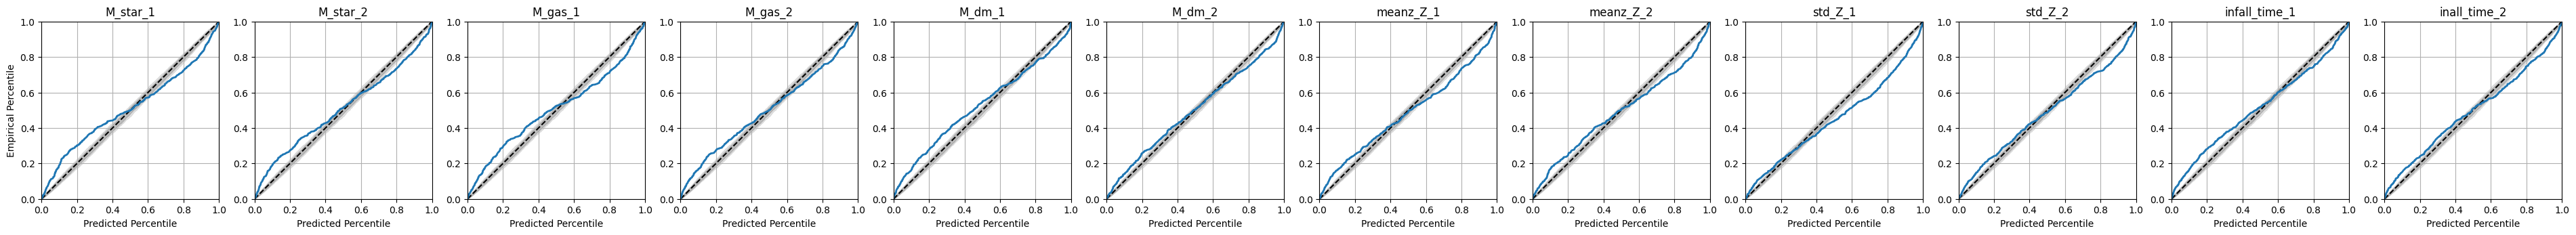

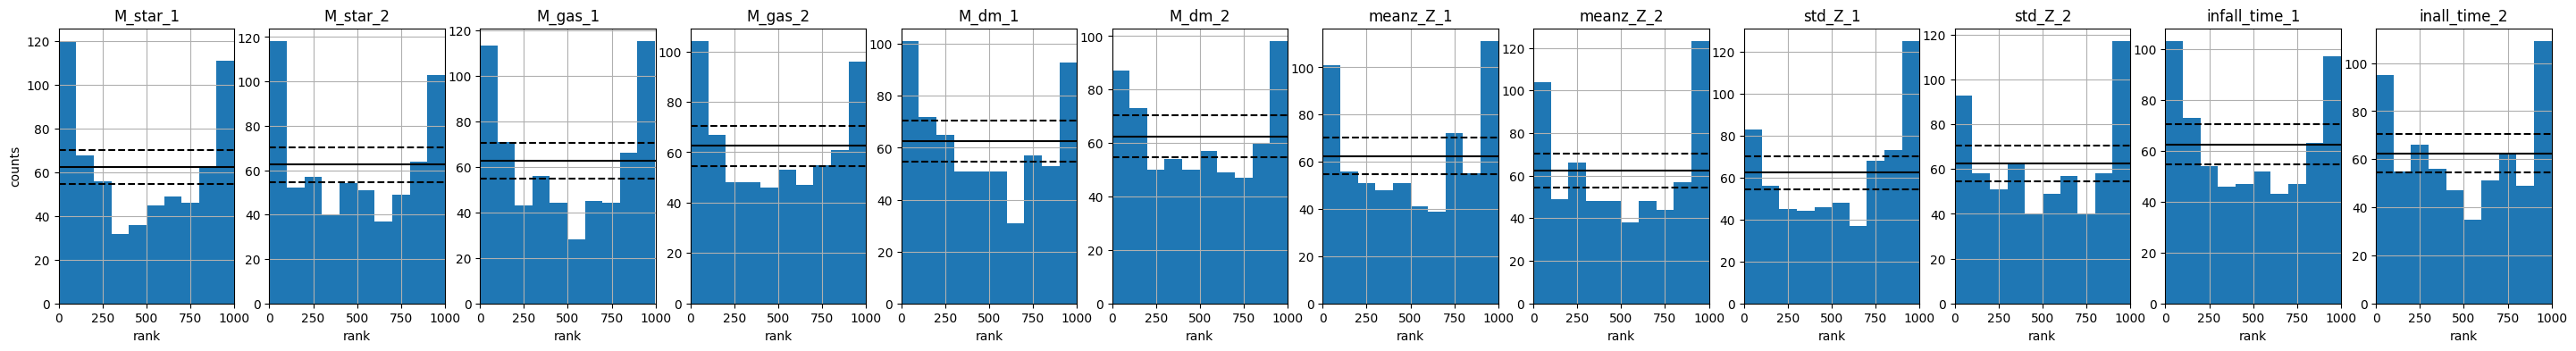

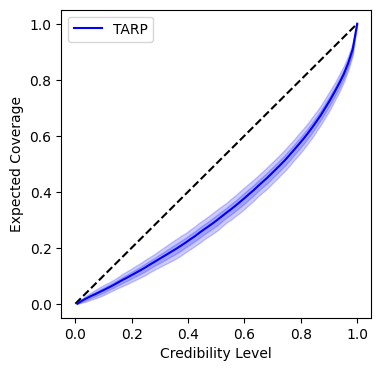

In [151]:
# calculate and plot the rank statistics to describe univariate posterior coverage
metric = PosteriorCoverage(
    num_samples=1000, sample_method='direct',
    labels=labels, plot_list = ["coverage", "histogram", "predictions", "tarp"]
)
fig = metric(
    posterior=posterior_ensemble,
    x=x[::8], theta=theta[::8]
)

In [153]:
metric = PlotSinglePosterior(
    num_samples=20000, sample_method='direct', 
    labels = ['M_star_1', 'M_star_2', 'M_gas_1', 'M_gas_2', 'M_dm_1', 'M_dm_2', 'meanz_Z_1', 'meanz_Z_2', 'std_Z_1', 'std_Z_2', 'infall_time_1', 'inall_time_2'],
    out_dir=None
)
fig = metric(
    posterior=posterior_ensemble,
    x_obs = x[ind], theta_fid=theta[ind],
)

Drawing 20000 posterior samples:   0%|          | 0/20000 [00:00<?, ?it/s]